# Data Inspection


In [13]:
from os import listdir
import gc

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import model_to_dot, plot_model

In [14]:
!ls data/train_images

sample-0.npy   sample-19.npy  sample-28.npy  sample-37.npy  sample-46.npy
sample-10.npy  sample-1.npy   sample-29.npy  sample-38.npy  sample-47.npy
sample-11.npy  sample-20.npy  sample-2.npy   sample-39.npy  sample-48.npy
sample-12.npy  sample-21.npy  sample-30.npy  sample-3.npy   sample-49.npy
sample-13.npy  sample-22.npy  sample-31.npy  sample-40.npy  sample-4.npy
sample-14.npy  sample-23.npy  sample-32.npy  sample-41.npy  sample-5.npy
sample-15.npy  sample-24.npy  sample-33.npy  sample-42.npy  sample-6.npy
sample-16.npy  sample-25.npy  sample-34.npy  sample-43.npy  sample-7.npy
sample-17.npy  sample-26.npy  sample-35.npy  sample-44.npy  sample-8.npy
sample-18.npy  sample-27.npy  sample-36.npy  sample-45.npy  sample-9.npy


In [28]:
i1 = np.load('data/train_images/sample-49.npy')
i1.shape

(15, 256, 256)

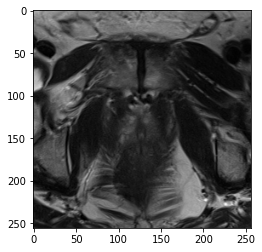

In [29]:
plt.imshow(i1[2], cmap='gray')

In [30]:
s1 = np.load('data/train_labels/sample-0.npy')
s1.shape

(16, 256, 256)

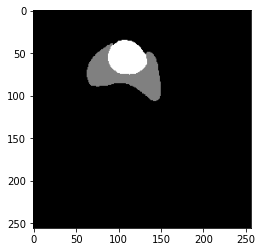

In [31]:
plt.imshow(s1[2], cmap='gray')

In [16]:
def get_network(input_shape=(256,256)):
    # layer notation: X_Y where X represents the "block" in which the layer is, and Y the position in the block 
    inputs = Input(shape=(input_shape[0], input_shape[1], 1)) # not sure why (256, 256, 1) as (256, 256,) didn't work...
    
    # padding=same, because our mask is the same size as the input. This is different than in the paper. Therefore, we don't crop
    
    # block 1
    conv1_1 = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', name='conv1_1')(inputs) # according to paper: unpadded 2D convs. Valid drops data if dimensions don't match
    conv1_2 = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', name='conv1_2')(conv1_1)

    # block 2, going down. Filter size doubles
    pool2_1 = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(conv1_2) # no activation function?
    conv2_2 = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', name='conv2_2')(pool2_1)
    conv2_3 = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', name='conv2_3')(conv2_2)
    
    # block 3, going down. Filter size doubles
    pool3_1 = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(conv2_3) # no activation function?
    conv3_2 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', name='conv3_2')(pool3_1)
    conv3_3 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', name='conv3_3')(conv3_2)
    
    # block 4, going down. Filter size doubles
    pool4_1 = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(conv3_3) # no activation function?
    conv4_2 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu', name='conv4_2')(pool4_1)
    conv4_3 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu', name='conv4_3')(conv4_2)
    
    # block 5, going down. Filter size doubles
    pool5_1 = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(conv4_3) # no activation function?
    conv5_2 = Conv2D(filters=1024, kernel_size=(3,3), padding='same', activation='relu', name='conv5_2')(pool5_1)
    conv5_3 = Conv2D(filters=1024, kernel_size=(3,3), padding='same', activation='relu', name='conv5_3')(conv5_2) # this leaves us with 10x10x1024 vs 28x28x1024 as in the paper. Maybe one step too deep for our input size
    
    # block 6, going up. 2x2 up convolution + concatenation from block 4
    # here: stride refers to the output and not the input
    up6_1 = Conv2DTranspose(filters=512, kernel_size=(1,1), strides=(2,2), padding='same')(conv5_3) # not sure if up-sampling or deconvolution. Video https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/ says learned feature map. Therefore, a proper deconvolution makes more sense, as up-sampling is also sparse
    concat6_3 = Concatenate()([conv4_3, up6_1])
    conv6_4 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu', name='conv6_2')(concat6_3)
    conv6_5 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu', name='conv6_3')(conv6_4)

    # block 7, going up. 2x2 up convolution + concatenation from block 3
    up7_1 = Conv2DTranspose(filters=256, kernel_size=(1,1), strides=(2,2), padding='same')(conv6_5) 
    concat7_3 = Concatenate()([conv3_3, up7_1])
    conv7_4 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', name='conv7_2')(concat7_3)
    conv7_5 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', name='conv7_3')(conv7_4)

    # block 8, going up. 2x2 up convolution + concatenation from block 2
    up8_1 = Conv2DTranspose(filters=128, kernel_size=(1,1), strides=(2,2), padding='same')(conv7_5) 
    concat8_3 = Concatenate()([conv2_3, up8_1])
    conv8_4 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', name='conv8_2')(concat8_3)
    conv8_5 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', name='conv8_3')(conv8_4)

    
    # block 9, going up. 2x2 up convolution + concatenation from block 2 + 1x1 conv. Final block
    up9_1 = Conv2DTranspose(filters=128, kernel_size=(1,1), strides=(2,2), padding='same')(conv8_5) 
    concat9_2 = Concatenate()([conv1_2, up9_1])
    conv9_3 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', name='conv9_3')(concat9_2)
    conv9_4 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', name='conv9_4')(conv9_3)
    out_layer = Conv2D(filters=3, kernel_size=(1,1), padding='same', name='out_layer', activation='softmax')(conv9_4)
    
    
    model = Model(inputs=inputs, outputs=out_layer)
    # random choice of adam and binary cross entropy loss. Metric is also wrong, need to implement IoU metric
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 256, 256, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
conv1_2 (Conv2D)                (None, 256, 256, 64) 36928       conv1_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 128, 128, 64) 0           conv1_2[0][0]                    
____________________________________________________________________________________________

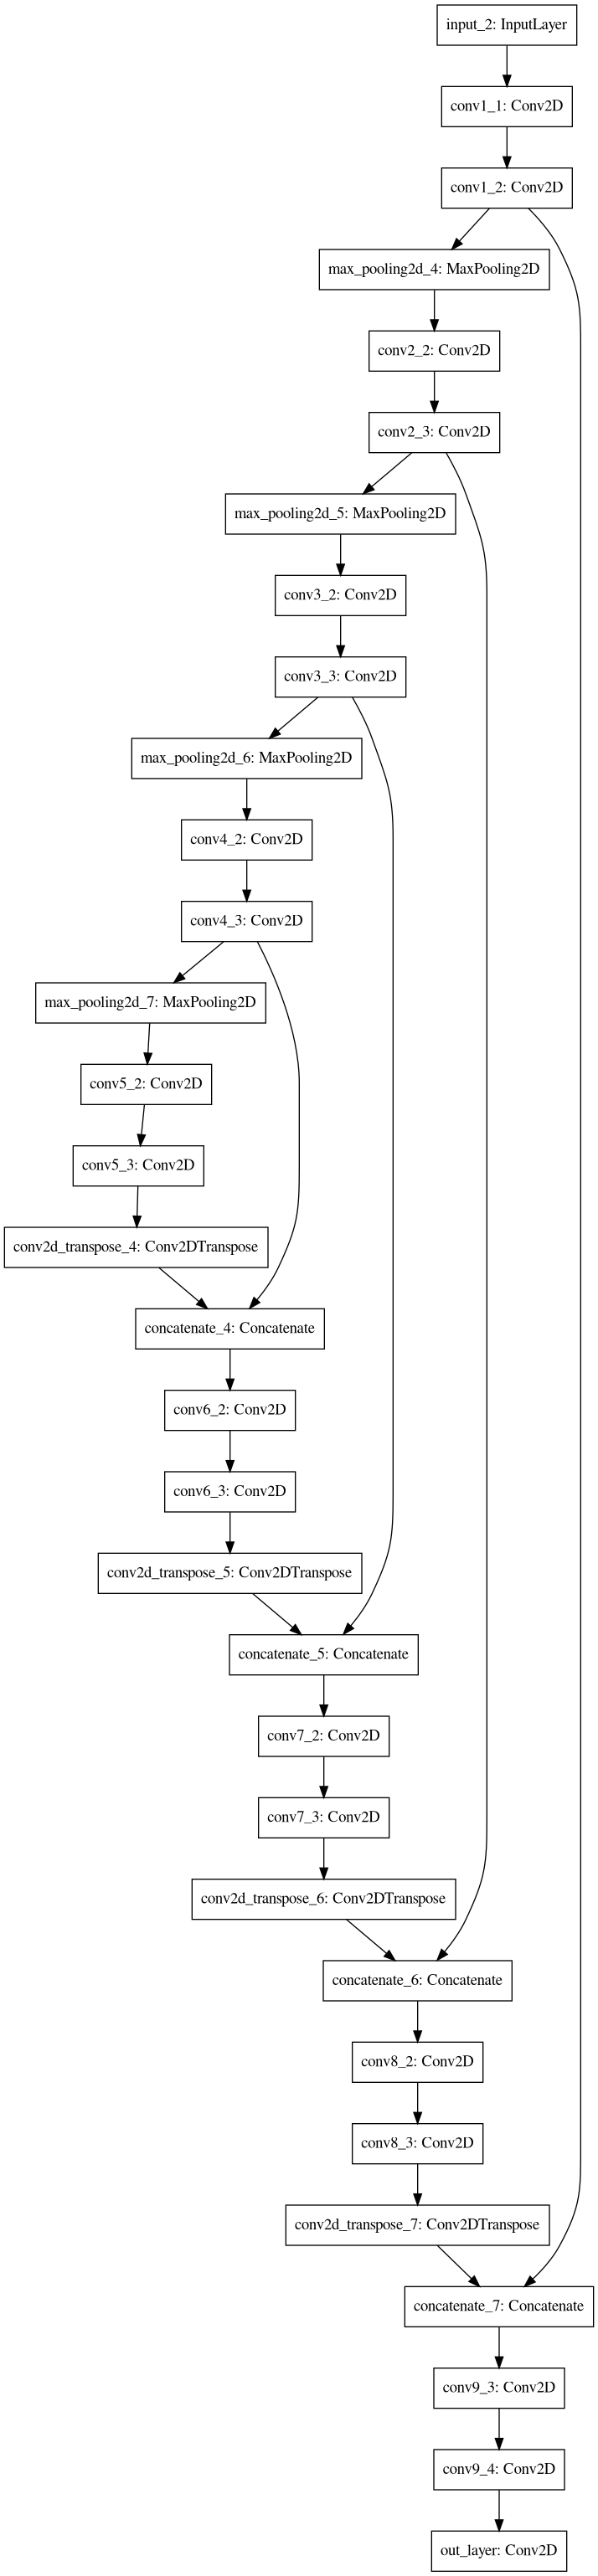

In [17]:
model = get_network()
model.summary()
plot_model(model)

In [18]:
"""
The original y is an x,y grayscale (0-255) image with 3 colors: 0, 1 and 2. Background, gland, peripheral zone.
We however have 3 different outputs, therefore we split the image into 3 images (one hot encoding) that each have 0/1
if we see the respective class.
"""
def get_y(y_in):
    num_images = y_in.shape[0]
    y = np.zeros((num_images,256,256,3))
    i = 0
    for img in y_in:

        tmp = np.copy(img)
        # layer of background pixels
        tmp[tmp==0] = 3
        tmp[tmp<3] = 0 
        tmp[tmp==3] = 1 
        y[i,:,:,0] = np.reshape(tmp, (256,256))
        #if(i == 2):
        #    fig = plt.figure()
        #    fig.add_subplot(1, 2, 1)
        #    plt.imshow(img, cmap='gray')
        #    fig.add_subplot(1, 2, 2)
        #    plt.imshow(y[i,:,:,0], cmap='gray')

        # layer of peripheral pixels
        tmp = np.copy(img)
        tmp[tmp != 1] = 0
        y[i,:,:,1] = np.reshape(tmp, (256,256))
        #if(i == 2):
        #    fig = plt.figure()
        #    fig.add_subplot(1, 2, 1)
        #    plt.imshow(img, cmap='gray')
        #    fig.add_subplot(1, 2, 2)
        #    plt.imshow(y[i,:,:,1], cmap='gray')

        # layer of gland pixels
        tmp = np.copy(img)
        tmp[tmp != 2] = 0
        tmp[tmp == 2] = 1
        y[i,:,:,2] = np.reshape(tmp, (256,256))
        #if(i == 2):
        #    fig = plt.figure()
        #    fig.add_subplot(1, 2, 1)
        #    plt.imshow(img, cmap='gray')
        #    fig.add_subplot(1, 2, 2)
        #    plt.imshow(y[i,:,:,2], cmap='gray')

        i += 1
    return y

In [19]:
files = listdir('data/train_images')
xs_train = []
ys_train = []

xs_test = []
ys_test = []
i = 0
"""
Load, convert and concatenate the data. We might split the train data to train/test because there are no labels for the test images
"""
for file in files:
    x = np.load('data/train_images/'+file)
    y_loaded = np.load('data/train_labels/'+file)
    y = get_y(y_loaded)
    
    # no test labels. Therefore, we split train set into train/test
    if(i <= 45):
        xs_train.append(x)
        ys_train.append(y)
    else:
        xs_test.append(x)
        ys_test.append(y)
    i += 1
X_train = np.concatenate(xs_train)
Y_train = np.concatenate(ys_train)

X_test = np.concatenate(xs_test)
Y_test = np.concatenate(ys_test)

In [22]:
model.fit(X_train, Y_train , batch_size=15, epochs=35, verbose=1)

Epoch 1/35
52/52 [==============================] - 38s 739ms/step - loss: 0.4376 - accuracy: 0.9121
Epoch 2/35
52/52 [==============================] - 35s 671ms/step - loss: 0.2358 - accuracy: 0.9332
Epoch 3/35
52/52 [==============================] - 35s 670ms/step - loss: 0.1369 - accuracy: 0.9325
Epoch 4/35
52/52 [==============================] - 35s 673ms/step - loss: 0.1129 - accuracy: 0.9323
Epoch 5/35
52/52 [==============================] - 35s 675ms/step - loss: 0.0962 - accuracy: 0.9348
Epoch 6/35
52/52 [==============================] - 35s 675ms/step - loss: 0.0924 - accuracy: 0.9366
Epoch 7/35
52/52 [==============================] - 36s 692ms/step - loss: 0.0863 - accuracy: 0.9398
Epoch 8/35
52/52 [==============================] - 37s 715ms/step - loss: 0.0844 - accuracy: 0.9406
Epoch 9/35
52/52 [==============================] - 37s 710ms/step - loss: 0.0794 - accuracy: 0.9475
Epoch 10/35
52/52 [==============================] - 37s 706ms/step - loss: 0.0699 - accura

In [ ]:
model.evaluate(X_test, Y_test)

In [23]:
prediction = model.predict(X_test)

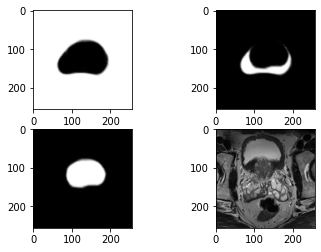

In [27]:
pred_0 = np.copy(prediction[10])
#pred_0[pred_0 > 0.15] = 1
#pred_0[pred_0 <= 0.15] = 0

fig = plt.figure()
fig.add_subplot(2,2,1)
plt.imshow(pred_0[:,:,0], cmap='gray')
fig.add_subplot(2,2,2)
plt.imshow(pred_0[:,:,1], cmap='gray')
fig.add_subplot(2,2,3)
plt.imshow(pred_0[:,:,2], cmap='gray')
fig.add_subplot(2,2,4)
plt.imshow(X_test[30], cmap='gray')


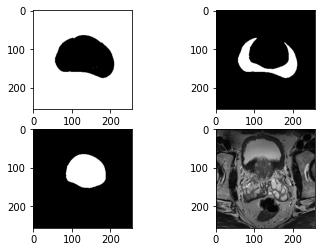

In [26]:
y_plot = Y_test[10]

fig = plt.figure()
fig.add_subplot(2,2,1)
plt.imshow(y_plot[:,:,0], cmap='gray')
fig.add_subplot(2,2,2)
plt.imshow(y_plot[:,:,1], cmap='gray')
fig.add_subplot(2,2,3)
plt.imshow(y_plot[:,:,2], cmap='gray')
fig.add_subplot(2,2,4)
plt.imshow(X_test[30], cmap='gray')

In [ ]:
gc.collect()